In [57]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\Users\user\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'test', 'axes', 'pylab', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [58]:
#train = pd.read_csv('C:/Users/user/Desktop/data/train.csv')#,',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#plt.figure(figsize(15,7))
#train.plot()
#plt.ylabel('Bicycle_train')
#pylab.show()

Вам предоставляются данные о почасовой аренде за два года. Для этого соревнования train состоит из первых 
19 дней каждого месяца, а набор тестов - с 20 до конца месяца. 
Необходимо спрогнозировать общее количество велосипедов, взятых напрокат в течение каждого часа, 
охватываемого тестовым набором, используя только информацию, доступную до периода аренды.
Также доступны данные о погоде.

In [59]:
import pylab
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# %config InlineBackend.figure_format = 'svg

In [62]:
train = pd.read_csv('C:/Users/user/Desktop/data/train.csv')
test = pd.read_csv('C:/Users/user/Desktop/data/test.csv')
samplesub = pd.read_csv('C:/Users/user/Desktop/data/sampleSubmission.csv')

In [63]:
train.shape
test.shape

(10886, 12)

(6493, 9)

In [64]:
train.head(2)
test.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000


Обучающий набор содержит 10886 наборов данных, тестовый набор содержит 6493 строки данных, и число столбцов в тестовом наборе должно быть предсказано.

In [65]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Необходимо разделить дату и время на дату и время, и Дата преобразуется в число дней с первого дня записи набора данных как новый набор функций.

In [66]:
train['date'] = train.datetime.apply(lambda x: x.split()[0])
train['hour'] = train.datetime.apply(lambda x: x.split()[1].split(':')[0])
begin = datetime(2011, 1, 1)
train['pirod'] = train.date.apply(lambda x: (datetime.strptime(x, "%Y-%m-%d") - begin).days)

Удалим избыточный столбец даты и времени

In [67]:
train = train.drop(['datetime'], axis=1)

этот набор данных не имеет пропущенных значений.

In [68]:
train.count() - len(train)

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
pirod         0
dtype: int64

## Управление выбросами 

<AxesSubplot:ylabel='count'>

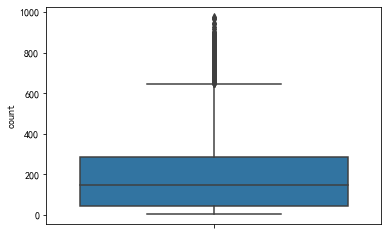

In [69]:
sn.boxplot(data=train,y="count",orient="v")

Сначала создаем рамочный график. При моделировании точки, превышающие верхнюю границу, обычно считаются аномальными точками данных. Однако, учитывая несоответствие между транспортными средствами, используемыми в часы пик в середине ночи, удаляются только значения, превышающие стандартное отклонение, превышающее его в три раза.

In [70]:
outliers_removed = train[np.abs(train['count'] - train['count'].mean()) <= (3 * train['count'].std())]

[Text(0.5, 1.0, 'Удалить выбросы')]

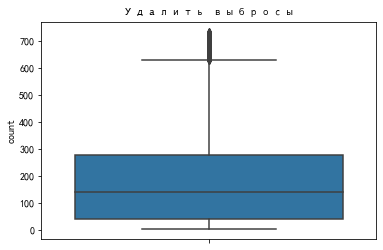

In [71]:
ax = sn.boxplot(data=outliers_removed,y="count",orient="v")
ax.set(title="Удалить выбросы")

## Корреляционный анализ

<AxesSubplot:>

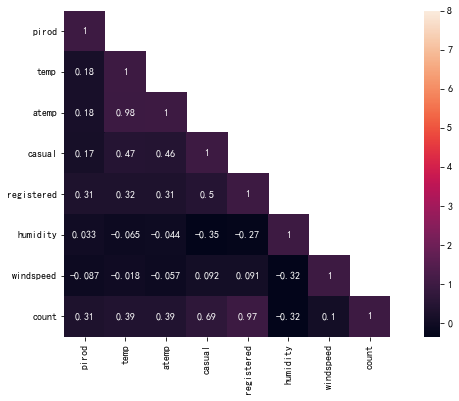

In [72]:
corr_mat = train[['pirod', 'temp', 'atemp', 'casual', 'registered','humidity', 'windspeed', 'count']].corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sn.heatmap(corr_mat, mask=mask, vmax=8, square=True, annot=True)

## Статистическое распределение

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Статистическое распределение графа')]

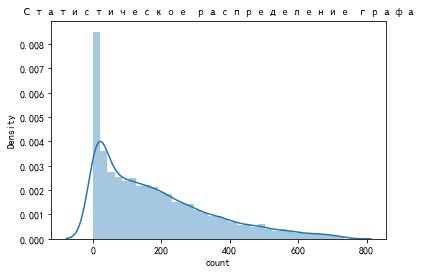

In [73]:
axes = sn.distplot(outliers_removed['count'])
axes.set(title="Статистическое распределение графа")

Распределение «count» несколько похоже на нормальное распределение, но в основном сосредоточено на небольшой территории

## Визуализация данных

<AxesSubplot:xlabel='hour', ylabel='count'>

[Text(0.5, 0, 'час'), Text(0.5, 1.0, 'Среднее использование в час в день')]

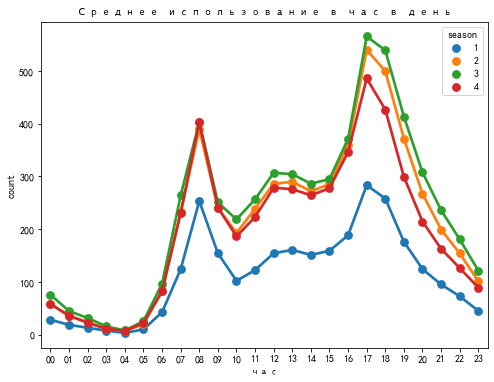

In [74]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
hourAggregated = pd.DataFrame(train.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True, ax=ax)
ax.set(xlabel='час', title="Среднее использование в час в день")

С сезонной точки зрения изменения в использовании примерно одинаковы: с точки зрения времени, использование имеет очевидные утренние и вечерние пики.

<AxesSubplot:xlabel='season', ylabel='count'>

[Text(0.5, 1.0, 'Среднеквартальный')]

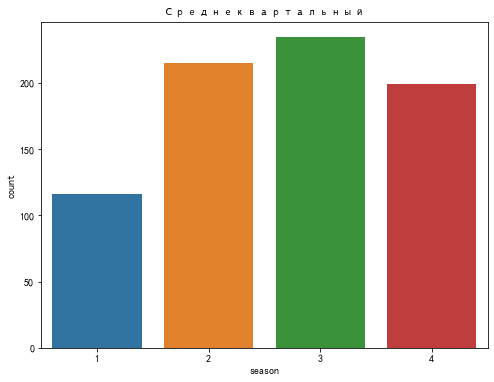

In [75]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
season_aggregated = pd.DataFrame(train.groupby("season")["count"].mean()).reset_index()
sn.barplot(data=season_aggregated,x=season_aggregated['season'],y=season_aggregated['count'],ax=ax)
ax.set(title="Среднеквартальный")

Весеннее использование относительно низкое, что может быть связано с важными западными праздниками весной, и количество поездок значительно сокращается.

<AxesSubplot:xlabel='hour', ylabel='value'>

[Text(0.5, 0, 'час'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Количество пользователей и не-пользователей в день'),
 None]

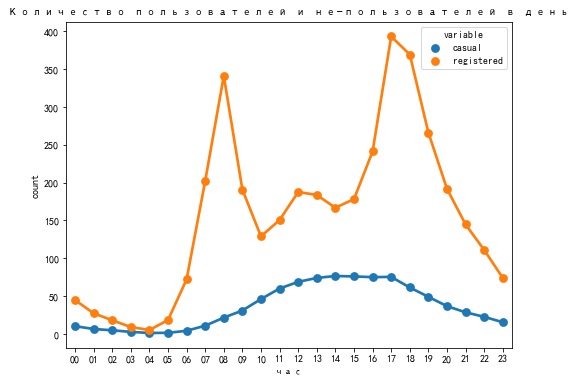

In [76]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8, 6)
hourTransformed = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax)
ax.set(xlabel='час', ylabel='count',title="Количество пользователей и не-пользователей в день",label='big')

Как видно из приведенного выше рисунка, пользователи-участники используют более регулярно и имеют фиксированный режим передвижения, что отражается в появлении утренних и вечерних пиков. Пользователи, не являющиеся членами, используют его только временно, что является более случайным с точки зрения объема

## Прогноз регрессии

In [77]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [78]:
train['date'] = train.datetime.apply(lambda x: x.split()[0])
train['hour'] = train.datetime.apply(lambda x: int(x.split()[1].split(':')[0]))
begin = datetime(2011, 1, 1)
train['pirod'] = train.date.apply(lambda x: (datetime.strptime(x, "%Y-%m-%d") - begin).days)
train = train.drop(['datetime'], axis=1)
train = train[np.abs(train['count'] - train['count'].mean()) <= (3 * train['count'].std())]

test['date'] = test.datetime.apply(lambda x: x.split()[0])
test['hour'] = test.datetime.apply(lambda x: int(x.split()[1].split(':')[0]))
test['pirod'] = test.date.apply(lambda x: (datetime.strptime(x, "%Y-%m-%d") - begin).days)
submmit_datetime = test['datetime']
test = test.drop(['datetime'], axis=1)

Удалим температуру тела «atemp», поскольку она имеет высокую линейную корреляцию с «temp»

In [79]:
#train = train.drop(['atemp'], axis=1)
#test = test.drop(['atemp'], axis=1)

In [80]:
test.head(1)
train.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,pirod
0,1,0,1,1,10.66,11.365,56,26.0027,2011-01-20,0,19


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,pirod
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,0


In [81]:
test.drop(['date'], axis=1).head(1)
train.drop(['date', 'casual', 'registered', 'count'], axis=1).head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,pirod
0,1,0,1,1,10.66,11.365,56,26.0027,0,19


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,pirod
0,1,0,0,1,9.84,14.395,81,0.0,0,0


In [82]:
#xArr = train.drop(['date','casual', 'registered', 'count'], axis=1).as_matrix()

In [83]:
from numpy.linalg import LinAlgError
def lwlr(testPoint, xArr, yArr, k = 1.0):
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    weights = np.mat(np.eye((m)))                                        
    for j in range(m):                                                  
        diffMat = testPoint - xMat[j, :]                                 
        weights[j, j] = np.exp(diffMat * diffMat.T/(-2.0 * k**2))
    xTx = xMat.T * (weights * xMat)                                        
    if np.linalg.det(xTx) == 0.0:
        print("Матрица является особой матрицей и не может быть инвертирована")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return float(testPoint * ws)

def lwlrTest(testArr, xArr, yArr, k=1.0):
    m = np.shape(testArr)[0]                                           
    yHat = np.zeros(m)    
    for i in range(m):
        try:
            yHat[i] = lwlr(testArr[i],xArr,yArr,k)
        except LinAlgError:
            yHat[i] = yHat[i-1]
    return yHat

## регрессионная модель Склеарна

In [84]:
test.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,date,hour,pirod
0,1,0,1,1,10.66,11.365,56,26.0027,2011-01-20,0,19


## Линейная регрессия

In [85]:
from sklearn.linear_model import LinearRegression

In [86]:
dataTrain = train.drop(['date','casual', 'registered', 'count'], axis=1)
dataTest = test.drop(['date'], axis=1)
yLabels = train["count"]
yLablesRegistered = train["registered"]
yLablesCasual = train["casual"]

In [87]:
dataTrain.head(1)
dataTest.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,pirod
0,1,0,0,1,9.84,14.395,81,0.0,0,0


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,pirod
0,1,0,1,1,10.66,11.365,56,26.0027,0,19


In [88]:
model = LinearRegression()
yLabelsLog = np.log1p(yLabels)
model.fit(X=dataTrain, y=yLabelsLog)

LinearRegression()

In [89]:
LR_preds = model.predict(dataTest)

In [90]:
np.exp(LR_preds).mean()

151.20271038485853

In [91]:
submission = pd.DataFrame({
    "datetime": submmit_datetime, 
    "count": np.exp(LR_preds)
})
submission.to_csv('LR_submission.csv', index=False)

In [92]:
print(submission)

                 datetime       count
0     2011-01-20 00:00:00   13.228792
1     2011-01-20 01:00:00   13.949019
2     2011-01-20 02:00:00   15.379639
3     2011-01-20 03:00:00   17.406407
4     2011-01-20 04:00:00   19.191620
...                   ...         ...
6488  2012-12-31 19:00:00  174.798696
6489  2012-12-31 20:00:00  192.726165
6490  2012-12-31 21:00:00  213.484876
6491  2012-12-31 22:00:00  253.464496
6492  2012-12-31 23:00:00  245.877087

[6493 rows x 2 columns]


## Хребет регрессии

In [93]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [94]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [95]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

#fig,ax= plt.subplots()
#fig.set_size_inches(8, 6)
#df = pd.DataFrame(grid_ridge_m.grid_scores)
#df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
#df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
#sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

{'alpha': 1000, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779238843042818


Cделаем прогнозы на тестовом наборе

In [96]:
Rd_model = Ridge(alpha=1000)
Rd_model.fit(dataTrain, yLabelsLog)
Rd_preds = Rd_model.predict(X=dataTest)
np.exp(Rd_preds).mean()

Ridge(alpha=1000)

151.0817706876184

In [97]:
submission = pd.DataFrame({
    "datetime": submmit_datetime, 
    "count": np.exp(Rd_preds)
})
submission.to_csv('Rd_submission.csv', index=False)

In [98]:
from sklearn.linear_model import Lasso

In [99]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit( dataTrain, yLabelsLog )
preds = grid_lasso_m.predict(X= dataTrain)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))



GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e+01, 1.00000000e+00, 5.00000000e-01, 3.33333333e-01,
       2.50000000e-01, 1.00000000e-01, 3.33333333e-02, 1.00000000e-02,
       5.00000000e-03, 3.33333333e-03, 2.50000000e-03, 1.25000000e-03,
       1.11111111e-03, 1.00000000e-03]),
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9780846547284869


Используя тот же метод для проверки подходящих параметров для модели регрессии Лассо, альфа составляет 0.005, но RMSLE, протестированный с обучающим набором, все еще не имеет разрыва с линейной регрессией.

In [100]:
Ls_model = Ridge(alpha=0.005)
Ls_model.fit(dataTrain, yLabelsLog)
Ls_preds = Ls_model.predict(X=dataTest)
np.exp(Ls_preds).mean()

Ridge(alpha=0.005)

151.20270881605538

In [101]:
submission = pd.DataFrame({
    "datetime": submmit_datetime, 
    "count": np.exp(Ls_preds)
})
submission.to_csv('Ls_submission.csv', index=False)

## Случайный лес

Запрос данных обнаружил, что случайный лес также может предсказать регрессионные данные, и, учитывая, что в наборе данных есть довольно много функций, которые не являются числовыми, но категориальными.

In [102]:
from sklearn.ensemble import RandomForestRegressor
Rf_model = RandomForestRegressor(n_estimators=100)
Rf_model.fit(dataTrain,yLabelsLog)
preds = Rf_model.predict(X= dataTrain)
rmsle(np.exp(yLabelsLog),np.exp(preds),False)

RandomForestRegressor()

0.11113074538453807

В обучающем наборе случайный лес имеет значительное улучшение по сравнению с общим методом регрессии, и случайный лес используется для прогнозирования тестового набора.

In [103]:
Rf_preds = Rf_model.predict(X=dataTest)
np.exp(Rf_preds).mean()

188.35913246905167

In [104]:
submission = pd.DataFrame({
    "datetime": submmit_datetime, 
    "count": np.exp(Rf_preds)
})
submission.to_csv('Rf_submission.csv', index=False)

## Xgboost

In [105]:
import xgboost as xg

def grid_search():
    xgr=xg.XGBRegressor(max_depth=8,min_child_weight=6,gamma=0.4)
    xgr.fit(dataTrain, yLabelsLog)
    parameters=[{'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]}]
    grid_search= GridSearchCV(estimator=xgr, param_grid=parameters, cv=10,n_jobs=-1)
    grid_search=grid_search.fit(dataTrain, yLabelsLog)
    best_accuracy=grid_search.best_score_
    best_parameters=grid_search.best_params_
    return best_accuracy, best_parameters

In [109]:
preds = xgr.predict(dataTrain)
rmsle(np.exp(yLabelsLog),np.exp(preds),False)


0.19529879210500223

In [110]:
xg_preds = xgr.predict(dataTest)
np.exp(Rf_preds).mean()

188.35913246905167

In [111]:
submission = pd.DataFrame({
    "datetime": submmit_datetime, 
    "count": np.exp(xg_preds)
})
submission.to_csv('xg_submission.csv', index=False)

In [114]:
train = train.set_index(['date'])

In [115]:
train.index = pd.to_datetime(train.index)

In [116]:
train.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
hour            int64
pirod           int64
dtype: object

In [117]:
class Stationary:
    def __init__(self, significance=.005):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):

        # Критерий Дики-Фуллера:
        print(timeseries)
        try:
            adfTest = adfuller(timeseries, autolag='AIC')

            self.pValue = adfTest[1]

            if (self.pValue < self.SignificanceLevel):
                self.isStationary = True
            else:
                self.isStationary = False
            #self.isStationary=True
            if printResults:
                dfResults = pd.Series(adfTest[0:4],
                                      index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

                # Добавить критические значения
                for key, value in adfTest[4].items():
                    dfResults['Critical Value (%s)' % key] = value

                print('Augmented Dickey-Fuller Test Results:')
                print(dfResults)
        except Exception as e:
          print(e)
          self.isStationary = False

In [118]:
sTest = Stationary()

In [119]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        # print(interval, dataset[i], dataset[i - interval])
        diff.append(value)
    return pd.Series(diff)

In [121]:
diff_values = difference(train['count'], 1)

In [122]:
xtrain, xtest = diff_values[0:-23], diff_values[-23:]

In [123]:
def timeseries_to_supervised(data, lag=1):
    dfx = pd.DataFrame(data)
    df = dfx.assign(**{
        '{} (t-{})'.format(col, t): dfx[col].shift(t)
        for t in range(lag+1)
        for col in dfx
    })

    df=df.drop([df.columns[0]], axis=1)
    df=df[df.columns[::-1]]
    return df[lag:]

In [124]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler()  
    
    # StandardScaler()
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    tr_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    ts_scaled = scaler.transform(test)
    
    return scaler, tr_scaled, ts_scaled

In [125]:
values_unscaled = np.concatenate((xtrain, xtest))
supervised_raw = timeseries_to_supervised(values_unscaled, 12)

In [126]:
supervised_raw = supervised_raw.values.astype("float32")

In [127]:
supervised_raw

array([[  24.,   -8.,  -19., ...,   20.,   28.,   10.],
       [  -8.,  -19.,  -12., ...,   28.,   10.,   12.],
       [ -19.,  -12.,    0., ...,   10.,   12.,    4.],
       ...,
       [-361., -153.,   36., ..., -233.,  -95.,  -73.],
       [-153.,   36.,   36., ...,  -95.,  -73.,  -39.],
       [  36.,   36.,  -23., ...,  -73.,  -39.,  -41.]], dtype=float32)

In [130]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import chart_studio.plotly as plot_mpl
#import plotly.graph_objs as go
import xgboost as xgb
#import keras.backend as K
#import tensorflow as tf

from math import sqrt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
#from pyramid.arima import auto_arima

from socket import socket
from statsmodels.tsa.seasonal import seasonal_decompose

#from keras.models import Sequential
#from keras.layers import Conv1D, LSTM, TimeDistributed, Dense
#from keras.optimizers import Adam
#from keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [131]:
scaler, train_scaled, test_scaled = scale(xtrain.values.reshape(len(xtrain), 1), xtest.values.reshape(len(xtest), 1))


In [132]:
values_scaled = np.concatenate((train_scaled, test_scaled))

In [133]:
supervised = timeseries_to_supervised(values_scaled, 12)

supervised_values = supervised.values.astype('float32')

In [134]:
supervised_train, supervised_test = supervised_raw[0:-23], supervised_raw[-23:]
train_scaled, test_scaled = supervised_values[0:-23], supervised_values[-23:]

In [135]:
train_scaled

array([[0.5668394 , 0.53367877, 0.5222798 , ..., 0.5626943 , 0.5709845 ,
        0.5523316 ],
       [0.53367877, 0.5222798 , 0.5295337 , ..., 0.5709845 , 0.5523316 ,
        0.55440414],
       [0.5222798 , 0.5295337 , 0.54196894, ..., 0.5523316 , 0.55440414,
        0.54611397],
       ...,
       [0.39481866, 0.6300518 , 0.58756477, ..., 0.453886  , 0.43834198,
        0.5046632 ],
       [0.6300518 , 0.58756477, 0.5139896 , ..., 0.43834198, 0.5046632 ,
        0.48911917],
       [0.58756477, 0.5139896 , 0.5015544 , ..., 0.5046632 , 0.48911917,
        0.50051814]], dtype=float32)

In [136]:
train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
test_X, test_y = test_scaled[:, :-1], test_scaled[:, -1]

In [137]:
train_y.reshape(train_y.shape[0], 1)

array([[0.5523316 ],
       [0.55440414],
       [0.54611397],
       ...,
       [0.5046632 ],
       [0.48911917],
       [0.50051814]], dtype=float32)

In [138]:
train_y

array([0.5523316 , 0.55440414, 0.54611397, ..., 0.5046632 , 0.48911917,
       0.50051814], dtype=float32)

In [139]:
train_y.shape

(10703,)

In [140]:
parameters = { 'gamma' : [0, 0.1, 0.3, 1], 'learning_rate' : [0.001, 0.01, 0.1], 
              'max_depth' : [2, 4, 6, 7, 12], 
              'n_estimators' : [10, 45, 90, 100, 150, 250],
              'nthread' : [-1], 'reg_alpha' : [1], 'reg_lambda' : [1], 'seed' : [10] }

bst = xgb.XGBRegressor()
xgb_grid = GridSearchCV(bst,
                        parameters,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        )
xgb_grid.fit(train_X, train_y, eval_set=[(train_X, train_y)], early_stopping_rounds=50)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 19.8min


[0]	validation_0-rmse:0.09896


[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 20.0min finished


[1]	validation_0-rmse:0.09219
[2]	validation_0-rmse:0.08612
[3]	validation_0-rmse:0.08077
[4]	validation_0-rmse:0.07587
[5]	validation_0-rmse:0.07176
[6]	validation_0-rmse:0.06809
[7]	validation_0-rmse:0.06477
[8]	validation_0-rmse:0.06186
[9]	validation_0-rmse:0.05943
[10]	validation_0-rmse:0.05717
[11]	validation_0-rmse:0.05531
[12]	validation_0-rmse:0.05352
[13]	validation_0-rmse:0.05202
[14]	validation_0-rmse:0.05066
[15]	validation_0-rmse:0.04953
[16]	validation_0-rmse:0.04849
[17]	validation_0-rmse:0.04761
[18]	validation_0-rmse:0.04677
[19]	validation_0-rmse:0.04603
[20]	validation_0-rmse:0.04538
[21]	validation_0-rmse:0.04483
[22]	validation_0-rmse:0.04425
[23]	validation_0-rmse:0.04376
[24]	validation_0-rmse:0.04329
[25]	validation_0-rmse:0.04290
[26]	validation_0-rmse:0.04256
[27]	validation_0-rmse:0.04227
[28]	validation_0-rmse:0.04194
[29]	validation_0-rmse:0.04170
[30]	validation_0-rmse:0.04143
[31]	validation_0-rmse:0.04123
[32]	validation_0-rmse:0.04102
[33]	validation_0

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    val

In [142]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=4, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=10,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=10,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)